### River forecasting

## Setup packages

In [51]:
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle


## Check the weather 

In [52]:
# You can upload csv data that NOAA sends you by email from https://www.ncdc.noaa.gov/cdo-web/
dataset_weather = pd.read_csv('Lakewood.csv', index_col=2)
remove = ['TOBS', 'STATION', 'NAME','PRCP']
weather_df = dataset_weather[dataset_weather.columns.difference(remove)]
dataset_weather.index.name = 'Date'
weather_df = weather_df.loc[f'1996-01-01':f'2021-07-01']
print(weather_df)

            TMAX  TMIN
Date                  
1996-01-01  40.0  20.0
1996-01-02  33.0  10.0
1996-01-03  45.0  11.0
1996-01-04  50.0  25.0
1996-01-05  25.0   4.0
...          ...   ...
2021-06-27  68.0  55.0
2021-06-28  71.0  53.0
2021-06-29  70.0  52.0
2021-06-30  75.0  52.0
2021-07-01  79.0  61.0

[9208 rows x 2 columns]


# Load river data

In [59]:
# load water flow data 
# add your token if you have an account with Denver Water and then you can download more data per day
page_size = 15000

def Load_gauge(gauge_label, gauge_name, start_date, end_date):
    flows=[]
    dates=[]
    URL = f'https://dwr.state.co.us/Rest/GET/api/v2/surfacewater/surfacewatertsday/?format=json&dateFormat=spaceSepToSeconds&fields=measDate%2Cvalue&abbrev={gauge_name}&min-measDate={start_date}&max-measDate={end_date}&pageSize={page_size}'
    try:
        urlData = requests.get(URL).content
        rawData = pd.read_json(urlData.decode('utf-8'))
        data=(rawData.ResultList)
        for count,entry in enumerate(data):
            dates.append(data.iloc[count]['measDate'])
            flows.append(data.iloc[count]['value'])
            
        date_series = pd.Series(dates) 
        flow_series = pd.Series(flows) 

        frame = {'Date': date_series, 'cfs_'+gauge_label: flow_series} 
        Gauge_Data = pd.DataFrame(frame) 

        Gauge_Data['Date'] = pd.to_datetime(Gauge_Data['Date'])
        Gauge_Data = Gauge_Data.set_index('Date')
        return Gauge_Data
    
    except:
        date_series = pd.Series(dates) 
        flow_series = pd.Series(np.zeros(11))

        frame = {'Date': date_series, 'cfs_'+gauge_label: flow_series} 
        Gauge_Data = pd.DataFrame(frame) 
    
        print(f'Oops!  No Data for {gauge_name} gauge. Filling with zeros.')
        return Gauge_Data
    
start_date = '01%2F01%2F1996' 
this_year = 2021
this_month = 7
end_date = f'{this_month}%2F01%2F{this_year}'
end_date = '07%2F01%2F2021'

names = { ('roberts','ROBTUNCO', 'red'):0, 
          ('waterton','PLASPLCO', 'blue'):1,
          ('grant', 'PLAGRACO', 'green'):2, 
          ('deckers', 'PLACHECO', 'navy'):3,
          ('aurora_out', 'AURSTRCO', 'brown'):4,
          ('below_strontia', 'PLASTRCO', 'black'):5,
          ('cheesman_inflow','SPACHECO', 'maroon'):6,
          ('11mileinflow','PLAHARCO', 'purple'):7,
          ('11mile_outflow','PLAGEOCO','brown'):8,
          ('above_chatfield','PLAWATCO','orange'):9,
          ('bailey', 'PLABAICO', 'purple'):10,
          ('conduit26', 'COND26CO', 'orange'):11,#
          ('Aurora_intake','AURSTRCO','gold'):12,#
          ('homestake_pipeline','HOMSPICO','green'):13,
          ('above_spinney','PLASPICO','blue'):14,
          ('below_dillon','BLUDILCO','blueviolet'):15,
          ('below_antero','PLAANTCO','olive'):16,
          ('below_brush','PLABRUCO','teal'):17,
          ('conduit20','COND20CO','silver'):19,#
          ('cheesman_res','CHERESCO','maroon'):20,
          ('middle_fork_prince','MFKPRICO','darkcyan'):21,
          ('SOUTH_FORK','SFKANTCO','sienna'):23,
          ('TARRYALL_BORDEN','TARBORCO','salmon'):24,
          ('williams_fork','WILFORCO','orange'):25,
          ('muddy_creek','MUDKRECO','maroon'):26,
          ('moffat_tunnel','MOFTUNCO','brown'):27,
          ('south_boulder','BOCBGRCO','olive'):28,
        } 

gauges = []

for count, (name, gauge_name, color) in enumerate(names):
    gauges.append(Load_gauge(name, f'{gauge_name}', start_date, end_date))
    print (f'created gauge we will call {name} using {gauge_name} shown in {color}')

created gauge we will call roberts using ROBTUNCO shown in red
created gauge we will call waterton using PLASPLCO shown in blue
created gauge we will call grant using PLAGRACO shown in green
created gauge we will call deckers using PLACHECO shown in navy
created gauge we will call aurora_out using AURSTRCO shown in brown
created gauge we will call below_strontia using PLASTRCO shown in black
created gauge we will call cheesman_inflow using SPACHECO shown in maroon
created gauge we will call 11mileinflow using PLAHARCO shown in purple
created gauge we will call 11mile_outflow using PLAGEOCO shown in brown
created gauge we will call above_chatfield using PLAWATCO shown in orange
created gauge we will call bailey using PLABAICO shown in purple
created gauge we will call conduit26 using COND26CO shown in orange
created gauge we will call Aurora_intake using AURSTRCO shown in gold
created gauge we will call homestake_pipeline using HOMSPICO shown in green
created gauge we will call above_sp

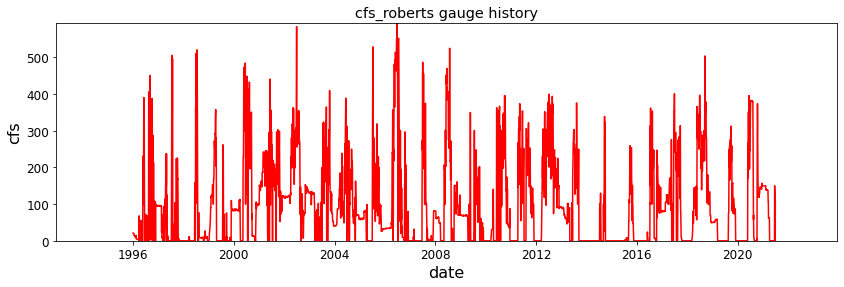

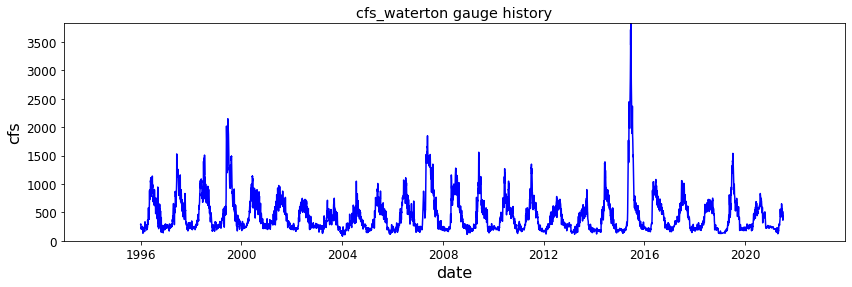

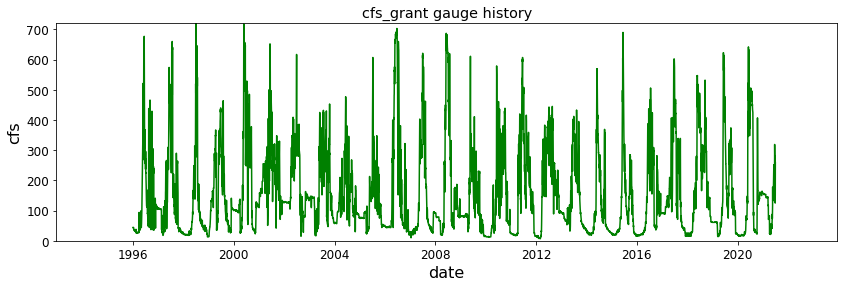

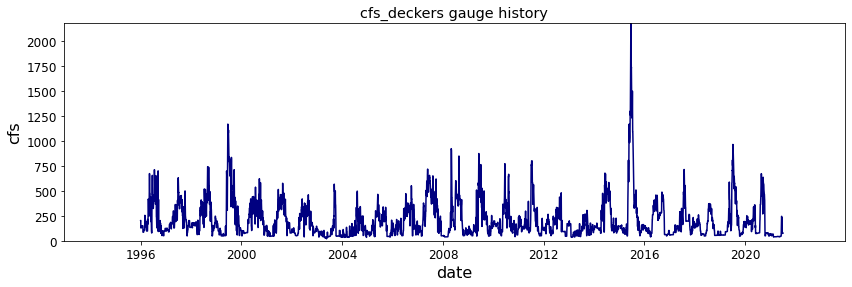

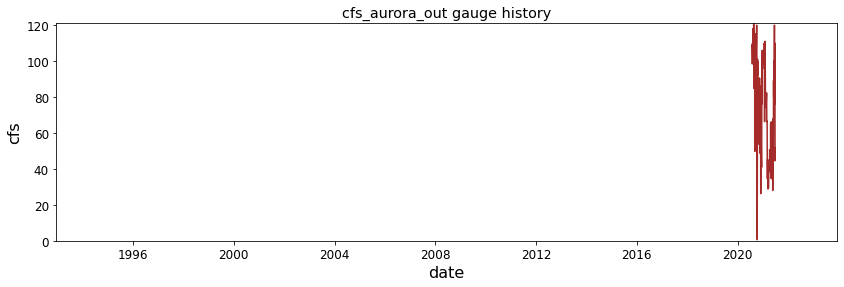

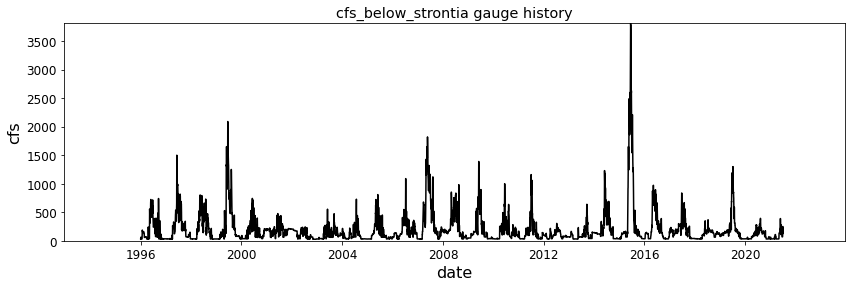

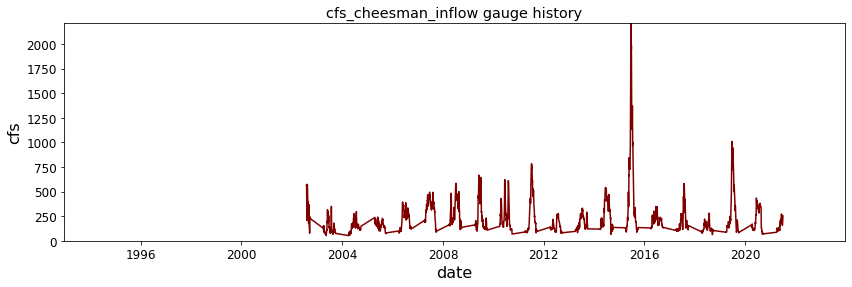

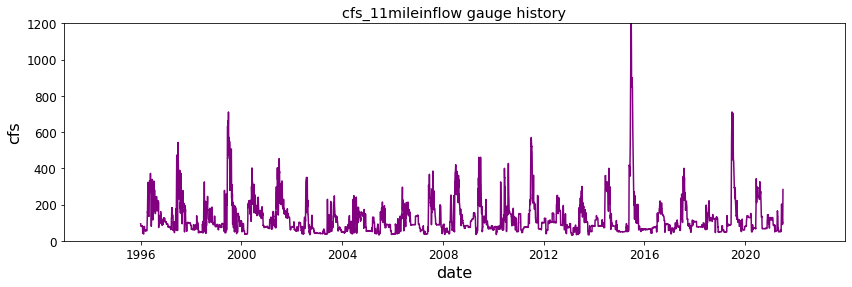

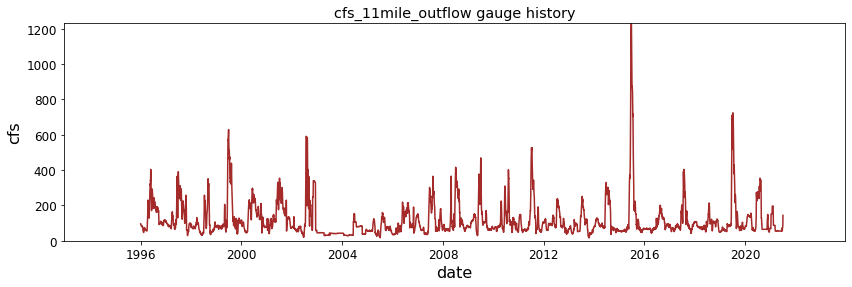

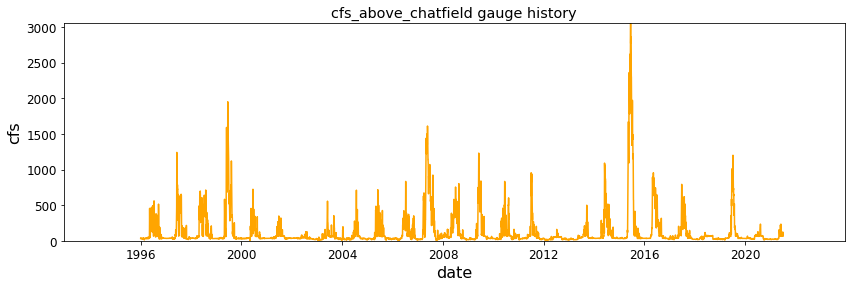

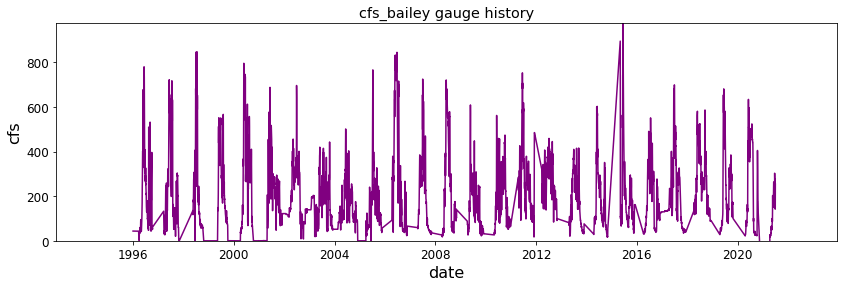

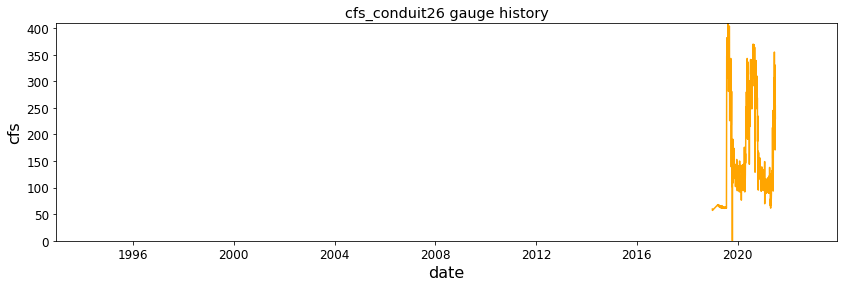

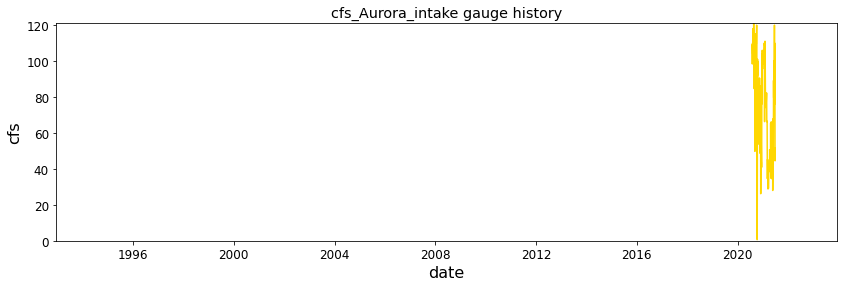

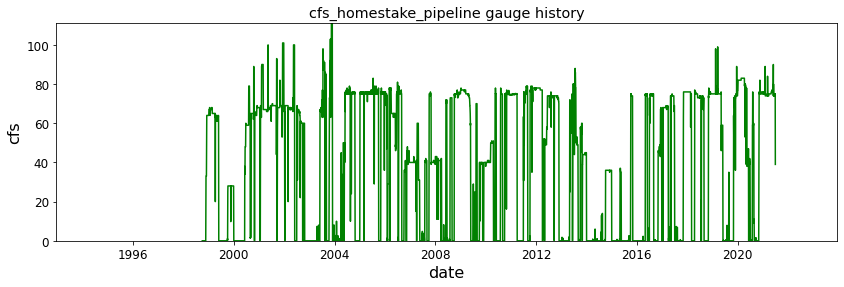

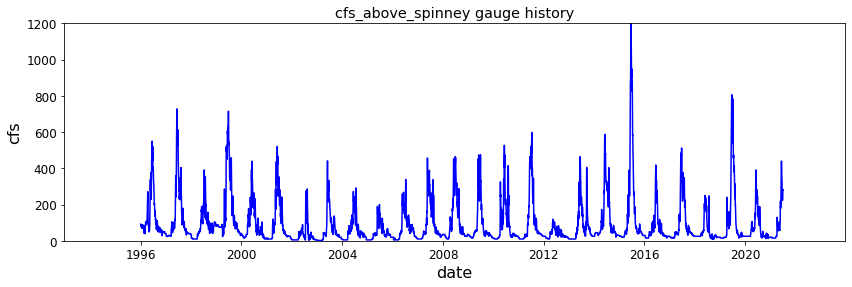

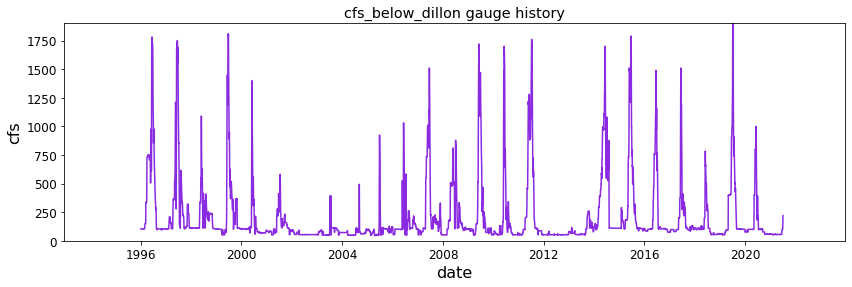

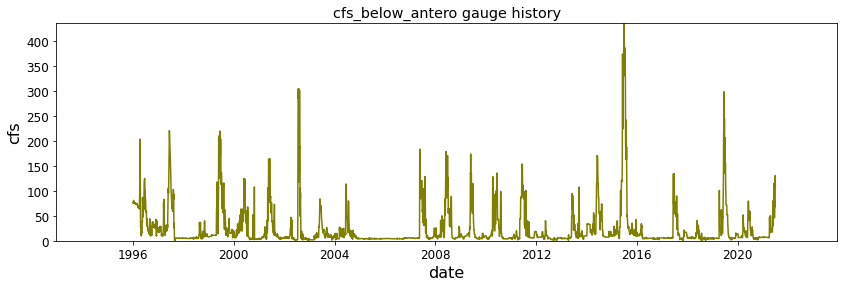

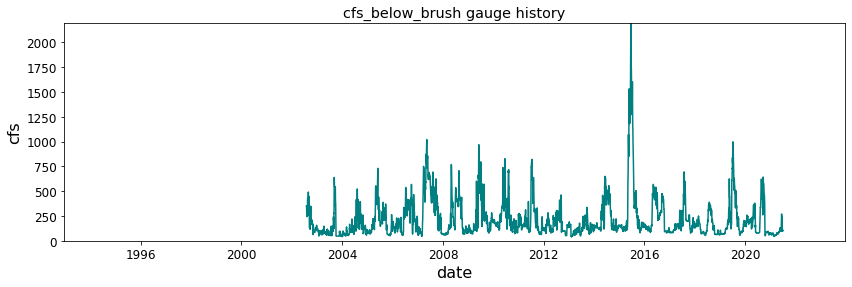

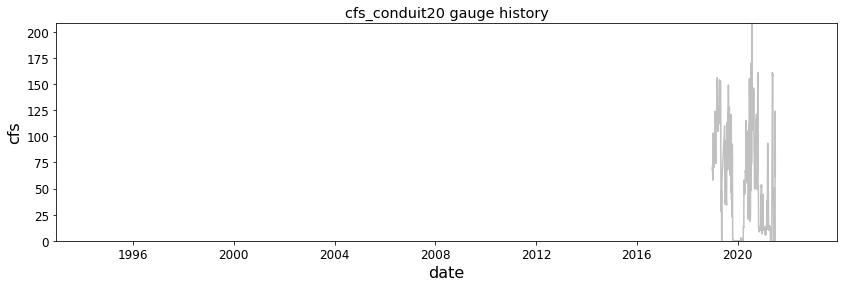

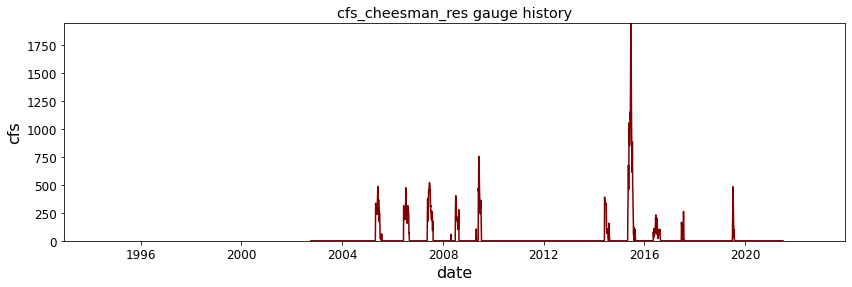

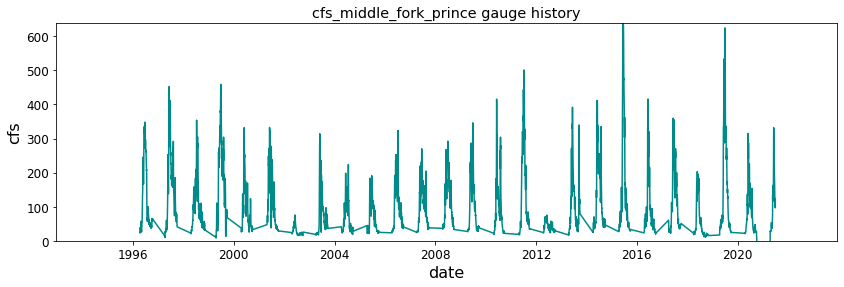

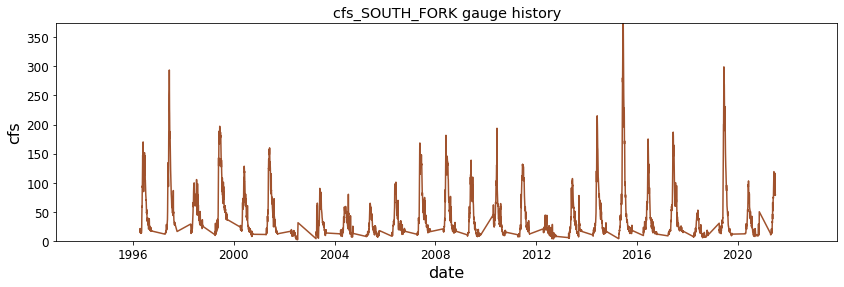

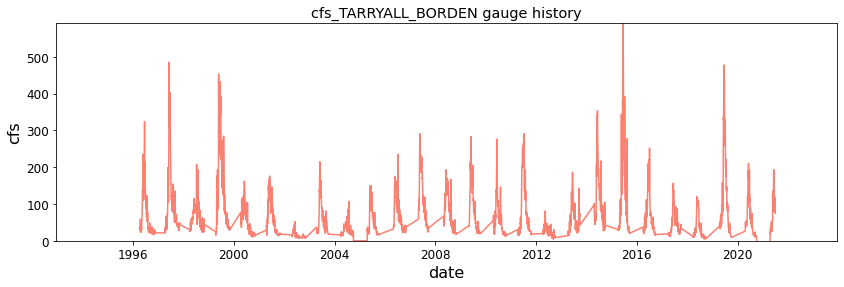

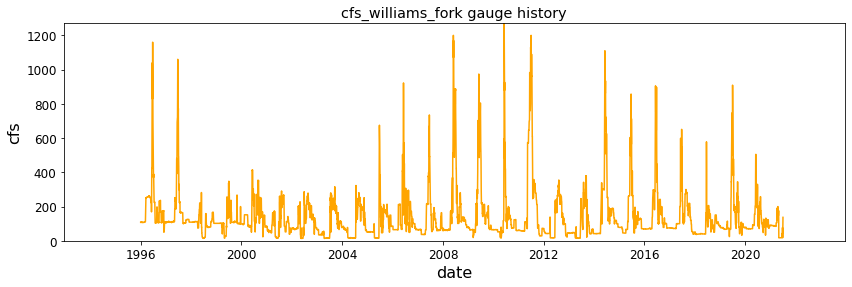

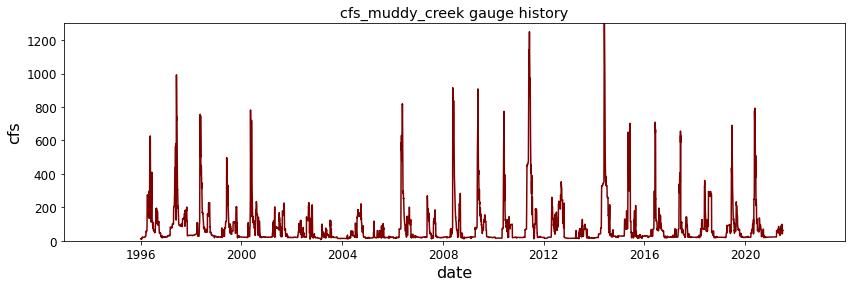

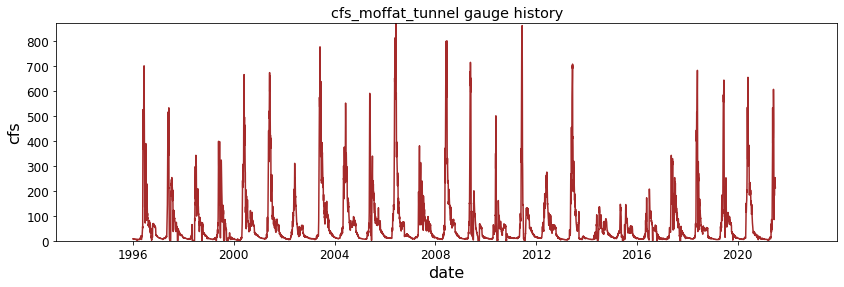

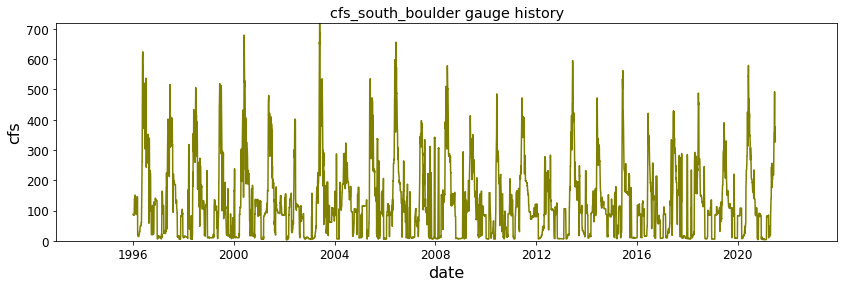

In [60]:
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (10, 6)

def plot_preview(gauges_in, x_start, x_stop, y_start=0, y_stop=300):

    for z,g in enumerate(zip(gauges_in, colors)):
        
        max_flow = (max(g[0][f'{title_names[z]}']))
        plt.figure(figsize=(14, 4))
        plt.rc('font', size=12)
        plt.xlabel('date', fontsize=16)
        plt.ylabel('cfs', fontsize=16)
        plt.title(f'{title_names[z]} gauge history')
        plt.plot(g[0],color=colors[z])
        plt.xlim([x_start, x_stop])
        plt.ylim([y_start, max_flow])
        plt.show()
        
colors = []
plot_key1 = []
plot_key2 = []
title_names = []

def plot_simple(gauges_in, y_start=0, y_stop=300):

    for g in enumerate((gauges_in)):

        plt.figure(figsize=(14, 4))
        plt.rc('font', size=12)
        plt.xlabel('date', fontsize=16)
        plt.ylabel('cfs', fontsize=16)
        plt.plot(g[0])
        plt.ylim([y_start, y_stop])
        plt.show()


for count, (name, gauge_name, color) in enumerate(names):
    colors.append(color)
    title_names.append('cfs_'+name)
    plot_key1.append(color)
    plot_key1.append(name)

plot_preview(gauges, 8380, len(gauges)+19680,0,1500)

created gauge we will call cheesman_res using CHERESCO shown in maroon
created gauge we will call spinney_res using SPIRESCO shown in green
created gauge we will call CHATFIELD_res using CHARESCO shown in red


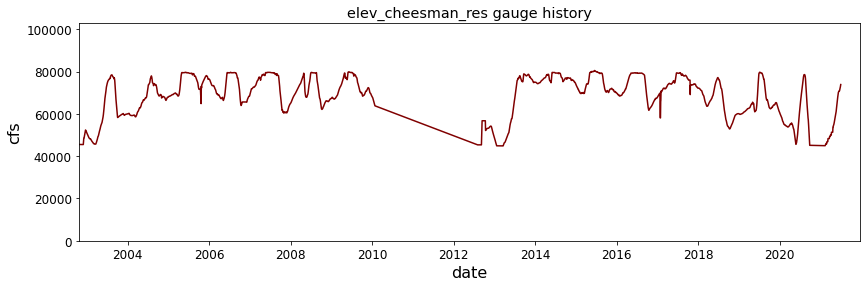

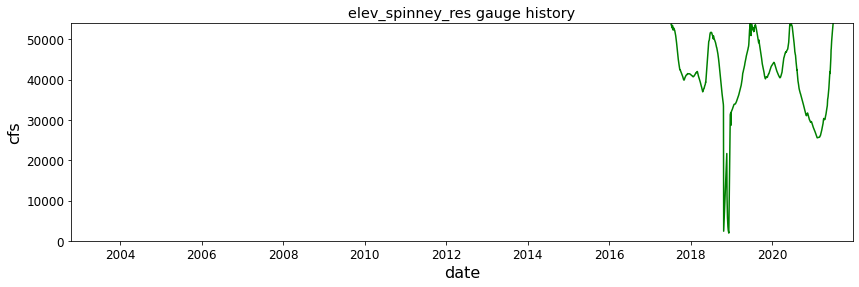

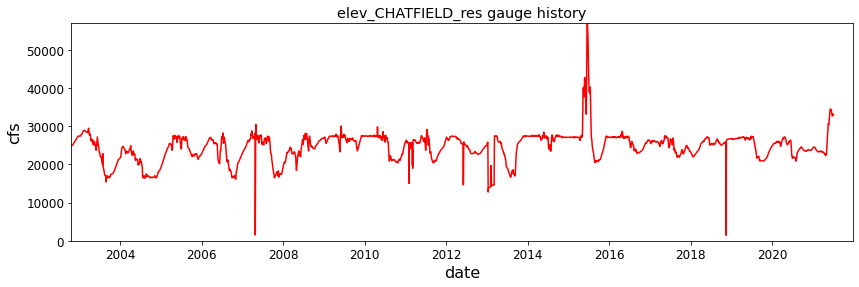

In [61]:
gauges_res = []

def load_reservoir(gauge_label, gauge_name, start_date, end_date):
    elevs=[]
    dates=[]
    URL = f'https://dwr.state.co.us/Rest/GET/api/v2/telemetrystations/telemetrytimeseriesday/?abbrev={gauge_name}&endDate={end_date}&parameter=STORAGE&startDate={start_date}'# add DISCHRG%2CSTORAGE%2C
    try:
        urlData = requests.get(URL).content
        rawData = pd.read_json(urlData.decode('utf-8'))
        data=(rawData.ResultList)

        for count,entry in enumerate(data):
            dates.append(data.iloc[count]['measDate'])
            elevs.append(data.iloc[count]['measValue'])
            
        date_series = pd.Series(dates) 
        elev_series = pd.Series(elevs) 

        frame = {'Date': date_series, 'elev_'+ gauge_label: elev_series} 
        Gauge_Data = pd.DataFrame(frame) 

        Gauge_Data['Date'] = pd.to_datetime(Gauge_Data['Date'])
        Gauge_Data = Gauge_Data.set_index('Date')
        return Gauge_Data
    
    except:
        date_series = pd.Series(dates) 
    
        flow_series = pd.Series(np.zeros(11))

        frame = {'Date': date_series, 'cfs_'+gauge_label: flow_series} 
        Gauge_Data = pd.DataFrame(frame) 
    
        print(f'Oops!  No Data for {gauge_name} gauge. Filling with zeros.')
        return Gauge_Data

names = {  
          ('cheesman_res', 'CHERESCO', 'maroon'):0,
          ('spinney_res', 'SPIRESCO', 'green'):1,
          ('CHATFIELD_res', 'CHARESCO','red'):2,
        } 
colors=[]
title_names = []
for count, (name, gauge_name, color) in enumerate(names):
    colors.append(color)
    title_names.append('elev_'+name)
    gauges_res.append(load_reservoir(name, f'{gauge_name}', start_date, end_date))
    print (f'created gauge we will call {name} using {gauge_name} shown in {color}')

plot_preview(gauges_res, 11980, len(gauges_res)+18980,0,99000)

## Merge River data and combine with weather data

In [62]:
def day_shift(data, col_names, days_in=1, days_out=1):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(0, days_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{col_names[j]}') for j in range(n_vars)]
        else:
            names += [(f'{col_names[j]}(t+%d)' % (i)) for j in range(n_vars)]
    for i in range(days_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{col_names[j]}(t-%d)' % (i)) for j in range(n_vars)]
        
    agg = pd.concat(cols, axis=1) 
    agg.columns = names
    return agg

gauges.extend(gauges_res)
combined_gauges = pd.concat(gauges, axis=1)
print('combined_gauges is',combined_gauges.shape)

combined_gauges_index = combined_gauges.index
col_names = combined_gauges.columns.values.tolist()
values = combined_gauges.values 

combo_gauge = day_shift(values, col_names, 0, 1) 
combo_gauge.index = combined_gauges_index

combo_gauge.describe()

combined_gauges is (9314, 30)


,cfs_roberts,cfs_waterton,cfs_grant,cfs_deckers,cfs_aurora_out,cfs_below_strontia,cfs_cheesman_inflow,cfs_11mileinflow,cfs_11mile_outflow,cfs_above_chatfield,...,cfs_middle_fork_prince,cfs_SOUTH_FORK,cfs_TARRYALL_BORDEN,cfs_williams_fork,cfs_muddy_creek,cfs_moffat_tunnel,cfs_south_boulder,elev_cheesman_res,elev_spinney_res,elev_CHATFIELD_res
count,9314.000000,9297.000000,9314.000000,9314.000000,307.000000,9314.000000,3428.000000,9314.000000,9314.000000,9314.00000,...,4388.000000,4665.000000,4878.000000,9314.000000,9314.000000,9314.000000,9314.000000,8115.000000,1414.000000,9259.000000
mean,94.597174,451.531354,155.643547,204.916470,74.358567,196.313399,238.234656,122.527593,116.539403,124.98091,...,104.002638,44.128553,69.178713,140.656539,81.966471,67.750844,127.691024,67444.057315,40888.177885,24683.377382
std,114.285050,330.723056,141.863621,186.542382,28.917505,283.272810,200.053189,99.798085,102.673673,255.81872,...,98.242736,46.649131,73.372400,147.927523,130.690455,113.722106,120.589559,9994.400639,8556.843430,3488.138847
min,0.000000,81.000000,7.000000,22.000000,0.670000,26.000000,53.000000,32.000000,17.000000,0.00000,...,-999.000000,2.030000,-999.000000,14.000000,7.110000,0.000000,2.800000,44841.000000,1913.250000,1453.477273
25%,0.000000,229.000000,45.000000,82.000000,48.200000,41.000000,121.000000,65.000000,62.000000,31.00000,...,37.100000,14.637000,23.345000,65.000000,21.000000,9.900000,19.000000,60542.622159,36121.809896,22915.656250
50%,60.000000,331.000000,108.000000,146.000000,75.800000,119.000000,177.000000,90.000000,83.000000,37.00000,...,65.651001,25.410000,43.795000,100.000000,28.600000,23.000000,99.000000,69314.169583,41433.296875,25501.375000
75%,148.000000,583.000000,226.000000,269.000000,101.000000,205.000000,290.250000,145.000000,130.000000,75.00000,...,145.968495,57.100000,91.000000,164.000000,83.775000,70.000000,179.000000,76211.635417,46958.263021,26997.132500
max,593.000000,3830.000000,720.000000,2180.000000,121.000000,3810.000000,2210.000000,1200.000000,1230.000000,3050.00000,...,638.056030,374.083008,590.726990,1270.000000,1300.000000,870.000000,718.000000,102767.483750,53963.458333,56958.645833


In [63]:
weather_df2=weather_df
weather_df2.index=weather_df.index.astype('datetime64[ns]')
combo_gauge.index=combo_gauge.index.astype('datetime64[ns]')

In [64]:
# Add weather to array
wet_gauges = combo_gauge.join(weather_df2, on = combo_gauge.index,how = 'left')
print(wet_gauges.index)
print('len: ', len(wet_gauges))
wet_gauges.describe()

DatetimeIndex(['1996-01-01', '1996-01-02', '1996-01-03', '1996-01-04',
               '1996-01-05', '1996-01-06', '1996-01-07', '1996-01-08',
               '1996-01-09', '1996-01-10',
               ...
               '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29',
               '2021-06-30', '2021-07-01'],
              dtype='datetime64[ns]', name='Date', length=9314, freq='D')
len:  9314


,cfs_roberts,cfs_waterton,cfs_grant,cfs_deckers,cfs_aurora_out,cfs_below_strontia,cfs_cheesman_inflow,cfs_11mileinflow,cfs_11mile_outflow,cfs_above_chatfield,...,cfs_TARRYALL_BORDEN,cfs_williams_fork,cfs_muddy_creek,cfs_moffat_tunnel,cfs_south_boulder,elev_cheesman_res,elev_spinney_res,elev_CHATFIELD_res,TMAX,TMIN
count,9314.000000,9297.000000,9314.000000,9314.000000,307.000000,9314.000000,3428.000000,9314.000000,9314.000000,9314.00000,...,4878.000000,9314.000000,9314.000000,9314.000000,9314.000000,8115.000000,1414.000000,9259.000000,9061.000000,9044.00000
mean,94.597174,451.531354,155.643547,204.916470,74.358567,196.313399,238.234656,122.527593,116.539403,124.98091,...,69.178713,140.656539,81.966471,67.750844,127.691024,67444.057315,40888.177885,24683.377382,64.486149,37.05429
std,114.285050,330.723056,141.863621,186.542382,28.917505,283.272810,200.053189,99.798085,102.673673,255.81872,...,73.372400,147.927523,130.690455,113.722106,120.589559,9994.400639,8556.843430,3488.138847,19.050924,16.26955
min,0.000000,81.000000,7.000000,22.000000,0.670000,26.000000,53.000000,32.000000,17.000000,0.00000,...,-999.000000,14.000000,7.110000,0.000000,2.800000,44841.000000,1913.250000,1453.477273,-8.000000,-16.00000
25%,0.000000,229.000000,45.000000,82.000000,48.200000,41.000000,121.000000,65.000000,62.000000,31.00000,...,23.345000,65.000000,21.000000,9.900000,19.000000,60542.622159,36121.809896,22915.656250,51.000000,25.00000
50%,60.000000,331.000000,108.000000,146.000000,75.800000,119.000000,177.000000,90.000000,83.000000,37.00000,...,43.795000,100.000000,28.600000,23.000000,99.000000,69314.169583,41433.296875,25501.375000,65.000000,37.00000
75%,148.000000,583.000000,226.000000,269.000000,101.000000,205.000000,290.250000,145.000000,130.000000,75.00000,...,91.000000,164.000000,83.775000,70.000000,179.000000,76211.635417,46958.263021,26997.132500,80.000000,51.00000
max,593.000000,3830.000000,720.000000,2180.000000,121.000000,3810.000000,2210.000000,1200.000000,1230.000000,3050.00000,...,590.726990,1270.000000,1300.000000,870.000000,718.000000,102767.483750,53963.458333,56958.645833,103.000000,74.00000


In [65]:
# Age the weather data. This stands in as what the weather forecast probably would have been

new_future = pd.DataFrame(wet_gauges['TMAX'], columns = ['TMAX'])

def fake_forecast(gauges, days):
    days_forward = range(days+1)
    
    for day in days_forward:
        gauges.loc[:,f'Tmax-{day}'] = gauges.loc[:,'TMAX'].shift(-day)

    return gauges

fake_forecast(wet_gauges, 5)
new_future.drop(columns=['TMAX'], axis=1, inplace=True)
print('unique: ', wet_gauges.index.is_unique)
wet_gauges.describe()

unique:  True


,cfs_roberts,cfs_waterton,cfs_grant,cfs_deckers,cfs_aurora_out,cfs_below_strontia,cfs_cheesman_inflow,cfs_11mileinflow,cfs_11mile_outflow,cfs_above_chatfield,...,elev_spinney_res,elev_CHATFIELD_res,TMAX,TMIN,Tmax-0,Tmax-1,Tmax-2,Tmax-3,Tmax-4,Tmax-5
count,9314.000000,9297.000000,9314.000000,9314.000000,307.000000,9314.000000,3428.000000,9314.000000,9314.000000,9314.00000,...,1414.000000,9259.000000,9061.000000,9044.00000,9061.000000,9060.000000,9059.000000,9058.000000,9057.000000,9056.000000
mean,94.597174,451.531354,155.643547,204.916470,74.358567,196.313399,238.234656,122.527593,116.539403,124.98091,...,40888.177885,24683.377382,64.486149,37.05429,64.486149,64.488852,64.492328,64.494480,64.496080,64.500442
std,114.285050,330.723056,141.863621,186.542382,28.917505,283.272810,200.053189,99.798085,102.673673,255.81872,...,8556.843430,3488.138847,19.050924,16.26955,19.050924,19.050238,19.048416,19.048366,19.048809,19.045338
min,0.000000,81.000000,7.000000,22.000000,0.670000,26.000000,53.000000,32.000000,17.000000,0.00000,...,1913.250000,1453.477273,-8.000000,-16.00000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000
25%,0.000000,229.000000,45.000000,82.000000,48.200000,41.000000,121.000000,65.000000,62.000000,31.00000,...,36121.809896,22915.656250,51.000000,25.00000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
50%,60.000000,331.000000,108.000000,146.000000,75.800000,119.000000,177.000000,90.000000,83.000000,37.00000,...,41433.296875,25501.375000,65.000000,37.00000,65.000000,65.500000,66.000000,66.000000,66.000000,66.000000
75%,148.000000,583.000000,226.000000,269.000000,101.000000,205.000000,290.250000,145.000000,130.000000,75.00000,...,46958.263021,26997.132500,80.000000,51.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
max,593.000000,3830.000000,720.000000,2180.000000,121.000000,3810.000000,2210.000000,1200.000000,1230.000000,3050.00000,...,53963.458333,56958.645833,103.000000,74.00000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000


## A Heatmap shows correlatations between each variable 

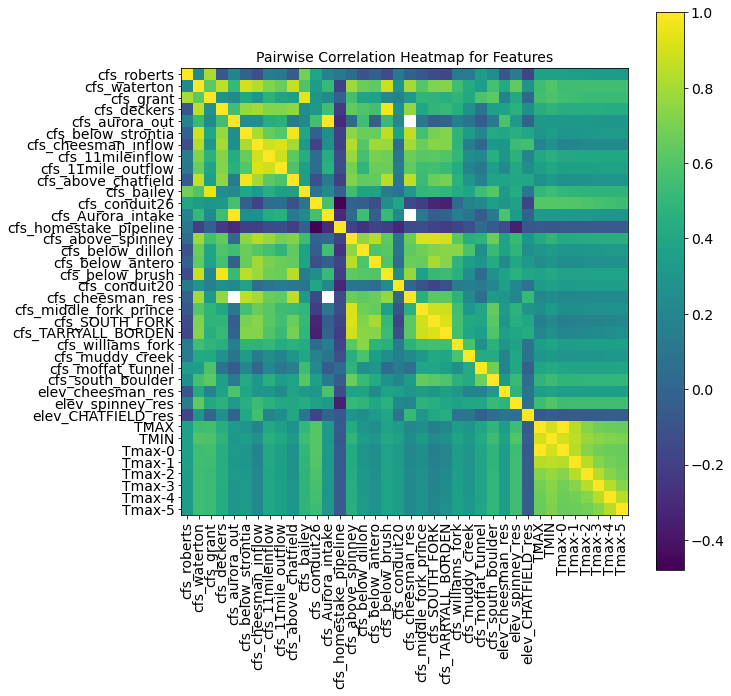

In [66]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Pairwise Correlation Heatmap for Features", fontsize=14)
    plt.show()
mpl.rcParams['figure.figsize'] = (11, 10)

show_heatmap(wet_gauges)

## Select and normalize data

In [67]:
date_list=(wet_gauges.index-min(wet_gauges.index)).days
print(date_list)
wet_gauges['days_past']=date_list
wet_gauges.describe()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9304, 9305, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313],
           dtype='int64', name='Date', length=9314)


,cfs_roberts,cfs_waterton,cfs_grant,cfs_deckers,cfs_aurora_out,cfs_below_strontia,cfs_cheesman_inflow,cfs_11mileinflow,cfs_11mile_outflow,cfs_above_chatfield,...,elev_CHATFIELD_res,TMAX,TMIN,Tmax-0,Tmax-1,Tmax-2,Tmax-3,Tmax-4,Tmax-5,days_past
count,9314.000000,9297.000000,9314.000000,9314.000000,307.000000,9314.000000,3428.000000,9314.000000,9314.000000,9314.00000,...,9259.000000,9061.000000,9044.00000,9061.000000,9060.000000,9059.000000,9058.000000,9057.000000,9056.000000,9314.000000
mean,94.597174,451.531354,155.643547,204.916470,74.358567,196.313399,238.234656,122.527593,116.539403,124.98091,...,24683.377382,64.486149,37.05429,64.486149,64.488852,64.492328,64.494480,64.496080,64.500442,4656.500000
std,114.285050,330.723056,141.863621,186.542382,28.917505,283.272810,200.053189,99.798085,102.673673,255.81872,...,3488.138847,19.050924,16.26955,19.050924,19.050238,19.048416,19.048366,19.048809,19.045338,2688.864537
min,0.000000,81.000000,7.000000,22.000000,0.670000,26.000000,53.000000,32.000000,17.000000,0.00000,...,1453.477273,-8.000000,-16.00000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000,0.000000
25%,0.000000,229.000000,45.000000,82.000000,48.200000,41.000000,121.000000,65.000000,62.000000,31.00000,...,22915.656250,51.000000,25.00000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,2328.250000
50%,60.000000,331.000000,108.000000,146.000000,75.800000,119.000000,177.000000,90.000000,83.000000,37.00000,...,25501.375000,65.000000,37.00000,65.000000,65.500000,66.000000,66.000000,66.000000,66.000000,4656.500000
75%,148.000000,583.000000,226.000000,269.000000,101.000000,205.000000,290.250000,145.000000,130.000000,75.00000,...,26997.132500,80.000000,51.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,6984.750000
max,593.000000,3830.000000,720.000000,2180.000000,121.000000,3810.000000,2210.000000,1200.000000,1230.000000,3050.00000,...,56958.645833,103.000000,74.00000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,9313.000000


In [68]:
column_indices = {name: i for i, name in enumerate(wet_gauges.columns)}
print(column_indices)

features_considered = [
    'cfs_conduit26',
    'cfs_conduit20',
    'Tmax-1',
    'Tmax-2',
    'Tmax-4',
    'cfs_roberts',  
    'cfs_deckers', 
    'cfs_grant', 
    'cfs_below_brush',
    'cfs_below_dillon',
    'cfs_waterton',
    'cfs_bailey', 
    'cfs_cheesman_inflow',
    'cfs_above_chatfield',
    'cfs_below_strontia',
    'TMAX',
    'Tmax-3',
    'days_past',
    'cfs_cheesman_res',
    'cfs_homestake_pipeline',
    'cfs_above_spinney',
    'cfs_11mile_outflow',
    'cfs_11mileinflow',
    'cfs_middle_fork_prince', 
    'cfs_SOUTH_FORK',
    'cfs_TARRYALL_BORDEN', 
    'elev_cheesman_res',  
    'elev_CHATFIELD_res',
    'cfs_below_antero',
    'cfs_Aurora_intake',
]

features = wet_gauges[features_considered]
features.index = wet_gauges.index
print(features.shape)
print(len(features_considered))

{'cfs_roberts': 0, 'cfs_waterton': 1, 'cfs_grant': 2, 'cfs_deckers': 3, 'cfs_aurora_out': 4, 'cfs_below_strontia': 5, 'cfs_cheesman_inflow': 6, 'cfs_11mileinflow': 7, 'cfs_11mile_outflow': 8, 'cfs_above_chatfield': 9, 'cfs_bailey': 10, 'cfs_conduit26': 11, 'cfs_Aurora_intake': 12, 'cfs_homestake_pipeline': 13, 'cfs_above_spinney': 14, 'cfs_below_dillon': 15, 'cfs_below_antero': 16, 'cfs_below_brush': 17, 'cfs_conduit20': 18, 'cfs_cheesman_res': 19, 'cfs_middle_fork_prince': 20, 'cfs_SOUTH_FORK': 21, 'cfs_TARRYALL_BORDEN': 22, 'cfs_williams_fork': 23, 'cfs_muddy_creek': 24, 'cfs_moffat_tunnel': 25, 'cfs_south_boulder': 26, 'elev_cheesman_res': 27, 'elev_spinney_res': 28, 'elev_CHATFIELD_res': 29, 'TMAX': 30, 'TMIN': 31, 'Tmax-0': 32, 'Tmax-1': 33, 'Tmax-2': 34, 'Tmax-3': 35, 'Tmax-4': 36, 'Tmax-5': 37, 'days_past': 38}
(9314, 30)
30


In [69]:
print(np.isnan(features.values).any())

combo_df_filled = features

for count, col in enumerate(features.columns):

    if combo_df_filled[col].isnull().any():
        print(col, 'starts with', combo_df_filled[col].isna().sum(), 'empty values')
        filler = np.mean(combo_df_filled[col])
        combo_df_filled.loc[:,col]=combo_df_filled[col].fillna(filler)      
        print(col, 'now has ', combo_df_filled[col].isna().sum(), 'empty values')
        
print(np.isnan(combo_df_filled.values).any())

True
cfs_conduit26 starts with 8477 empty values
cfs_conduit26 now has  0 empty values
cfs_conduit20 starts with 8441 empty values
cfs_conduit20 now has  0 empty values
Tmax-1 starts with 254 empty values
Tmax-1 now has  0 empty values
Tmax-2 starts with 255 empty values
Tmax-2 now has  0 empty values
Tmax-4 starts with 257 empty values
Tmax-4 now has  0 empty values
cfs_below_brush starts with 2404 empty values
cfs_below_brush now has  0 empty values
cfs_waterton starts with 17 empty values
cfs_waterton now has  0 empty values
cfs_bailey starts with 2630 empty values
cfs_bailey now has  0 empty values
cfs_cheesman_inflow starts with 5886 empty values
cfs_cheesman_inflow now has  0 empty values
TMAX starts with 253 empty values
TMAX now has  0 empty values
Tmax-3 starts with 256 empty values
Tmax-3 now has  0 empty values
cfs_cheesman_res starts with 3461 empty values
cfs_cheesman_res now has  0 empty values
cfs_homestake_pipeline starts with 1005 empty values
cfs_homestake_pipeline no

/opt/anaconda3/envs/forecasts/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [70]:
new_start = 1996
segment_one = combo_df_filled.loc[f'{1996}-01-01':f'{2012}-12-31'] 
segment_two = combo_df_filled.loc[f'{2015}-01-01':f'{2016}-12-31'] 
segment_three = combo_df_filled.loc[f'{2013}-01-01':f'{2014}-12-31']
segment_four = combo_df_filled.loc[f'{2017}-01-01':f'{this_year}-{this_month}-01'] 
all_segments = combo_df_filled.loc[f'{1996}-01-01':f'{this_year}-{this_month}-01']

trained_years_combo = pd.concat([segment_one,segment_four])
trained_years_first = segment_one
trained_years_second = segment_four
testing_years = segment_two 
val_years = segment_three 

In [72]:
# Z-score Normalization

means_train = []
stds_train = []
x_train_norm = []
x_val_norm = []
x_test_norm = []

for f in features_considered:
    
    trained_years_early = trained_years_first[f]
    trained_years_late = trained_years_second[f]
    trained_years_col = pd.concat([trained_years_early, trained_years_late])
    train_series = pd.Series(trained_years_col)

    train_mean = train_series.mean(skipna=True)
    train_std = train_series.std(skipna=True)
           
    means_train.append(train_mean)
    stds_train.append(train_std)
    
    x_train_norm.append(((trained_years_combo[f])-train_mean)/train_std)

    val_years_col = val_years[f]
    val_series = pd.Series(val_years_col)
    
    x_val_norm.append(((val_years[f])-train_mean)/train_std)
    x_test_norm.append(((testing_years[f])-train_mean)/train_std)


first_half = pd.DataFrame(x_train_norm).transpose()
second_half = pd.DataFrame(x_val_norm).transpose()
third_half = pd.DataFrame(x_test_norm).transpose()
first_half.columns = features.columns
second_half.columns = features.columns
third_half.columns = features.columns

combo_df_norm = first_half[:9861].merge(second_half, how='outer')#[:9861]
combo_df_norm = combo_df_norm.merge(third_half, how='outer')
combo_df_norm = combo_df_norm.merge(first_half[9861:], how='outer')
print('combo_df_norm.shape is:', combo_df_norm.shape)
print(combo_df_norm.columns)

means_train_dict = dict(zip(features_considered, means_train))
stds_train_dict = dict(zip(features_considered, stds_train))

combo_df_norm.index = all_segments.index

print(np.isnan(combo_df_norm.values).any())
print(np.isnan(second_half.values).any())

combo_df_norm.shape is: (9314, 30)
Index(['cfs_conduit26', 'cfs_conduit20', 'Tmax-1', 'Tmax-2', 'Tmax-4',
       'cfs_roberts', 'cfs_deckers', 'cfs_grant', 'cfs_below_brush',
       'cfs_below_dillon', 'cfs_waterton', 'cfs_bailey', 'cfs_cheesman_inflow',
       'cfs_above_chatfield', 'cfs_below_strontia', 'TMAX', 'Tmax-3',
       'days_past', 'cfs_cheesman_res', 'cfs_homestake_pipeline',
       'cfs_above_spinney', 'cfs_11mile_outflow', 'cfs_11mileinflow',
       'cfs_middle_fork_prince', 'cfs_SOUTH_FORK', 'cfs_TARRYALL_BORDEN',
       'elev_cheesman_res', 'elev_CHATFIELD_res', 'cfs_below_antero',
       'cfs_Aurora_intake'],
      dtype='object')
False
False


In [73]:
def out_iqr(s, k=2):
    q25, q75 = np.percentile(s, 10), np.percentile(s, 95)
    iqr = q75 - q25
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    return lower, upper

In [74]:
for col in combo_df_norm.columns:
    replaced_outliers = 0
    filler = np.mean(combo_df_norm[col])
    IQR_cutoff = out_iqr(combo_df_norm[col])

    for count, x in enumerate(combo_df_norm[col]):
        
        if combo_df_norm[col][count] > IQR_cutoff[1]:
            combo_df_norm[col][count] = filler
            replaced_outliers += 1
            
        if combo_df_norm[col][count] < IQR_cutoff[0]:
            combo_df_norm[col][count] = filler
            replaced_outliers += 1

    print(col, replaced_outliers)

cfs_conduit26 837
cfs_conduit20 1264
Tmax-1 0
Tmax-2 0
Tmax-4 0
cfs_roberts 0
cfs_deckers 16
cfs_grant 0
cfs_below_brush 26
cfs_below_dillon 0
cfs_waterton 15
cfs_bailey 2
cfs_cheesman_inflow 48
cfs_above_chatfield 48
cfs_below_strontia 40
TMAX 0
Tmax-3 0
days_past 0
cfs_cheesman_res 149
cfs_homestake_pipeline 0
cfs_above_spinney 9
cfs_11mile_outflow 27
cfs_11mileinflow 29
cfs_middle_fork_prince 2
cfs_SOUTH_FORK 16
cfs_TARRYALL_BORDEN 14
elev_cheesman_res 0
elev_CHATFIELD_res 27
cfs_below_antero 55
cfs_Aurora_intake 307


In [75]:
pickle_name = str('_data_manuscript')

file_to_write = open(f'combo_df_norm{pickle_name}.pkl', 'wb')
pickle.dump(combo_df_norm, file_to_write)
file_to_write.close()

file_to_write = open(f'means_train_dict{pickle_name}.pkl', 'wb')
pickle.dump(means_train_dict, file_to_write)
file_to_write.close()

file_to_write = open(f'stds_train_dict{pickle_name}.pkl', 'wb')
pickle.dump(stds_train_dict, file_to_write)
file_to_write.close()

file_to_write = open(f'features_considered{pickle_name}.pkl', 'wb')
pickle.dump(features_considered, file_to_write)
file_to_write.close()

# file_to_write = open(f'testing_data{pickle_name}.pkl', 'wb')
# pickle.dump(combo_df_norm, file_to_write)
# file_to_write.close()

print('done pickling data')

done pickling data
